In [1]:
import numpy as np 
import pandas as pd 
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import json
import networkx as nx
from networkx.readwrite import json_graph

In [125]:
# Import SNP data
data = pd.read_csv(
    './patient_snps_ci99.txt',
    sep='\t',
    index_col=0
)

# Code nucleotide values to numbers
data = data.replace("A", 0)
data = data.replace("T", 1)
data = data.replace("C", 2)
data = data.replace("G", 3)
data = data.replace("R", 4)
data = data.replace("K", 5)
data = data.replace("M", 6)
data = data.replace("Y", 7)
data = data.replace("S", 8)
data = data.replace("W", 9)

# Measure similarity between samples based on SNPs
data_comparisons = squareform(
    pdist(
        data.T, 
        metric='hamming'
    )
)

# Convert data to table
table = pd.DataFrame(
    data_comparisons, 
    columns=data.columns.tolist(), 
    index=data.columns.tolist()
)

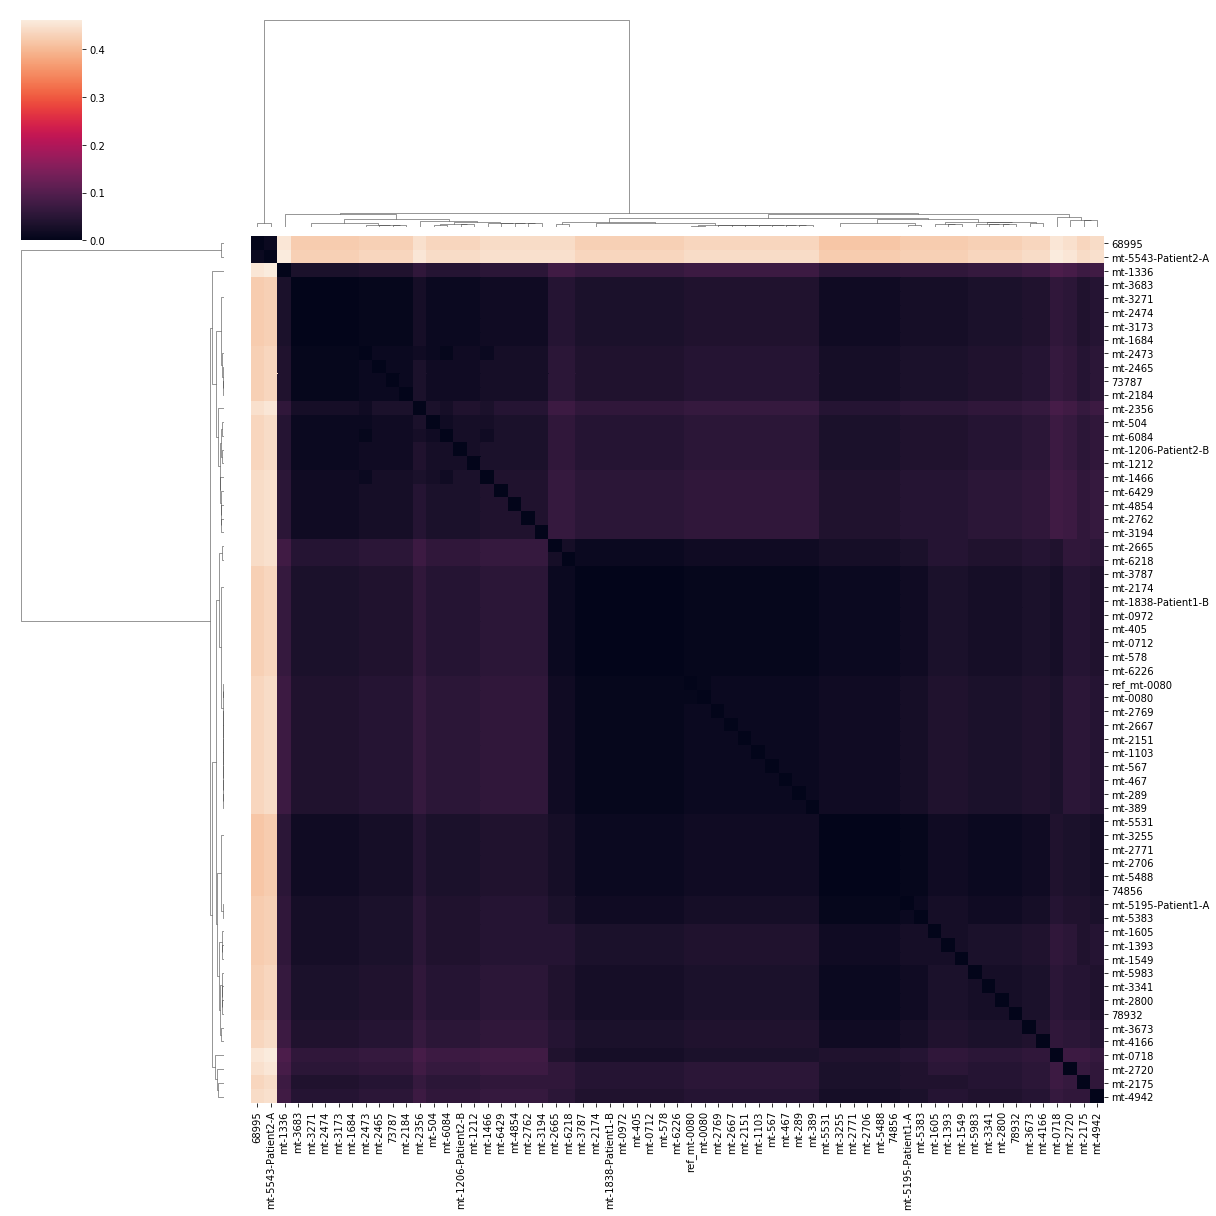

In [124]:
# Visualize similarity matrix
sns.clustermap(
    table, 
    figsize=(17,17)
)

In [108]:
# Create temporal metadata dictionary 
meta = pd.read_csv(
    './patient_metadata.txt',
    sep='\t')

meta_dict = pd.Series(
    meta['normalized_time'].values, 
    index=meta['sample']
).to_dict()

In [122]:
meta

,sample,Date_diagnosis,Year,Month,normalized_time
0,ref_mt-0080,0,0,1,0
1,mt-0080,2012-1,12,1,144
2,mt-289,2012-1,12,1,144
3,mt-578,2012-1,12,1,144
4,mt-6226,2012-1,12,1,144
...,...,...,...,...,...
58,mt-2356,2012-5,12,5,148
59,mt-2473,2012-5,12,5,148
60,mt-6084,2012-10,12,10,153
61,68995,2007-11,7,11,94


In [119]:
# Progress through time, if sample is introduced, add its node and edges
G = nx.DiGraph()

# Ignore list (refs and outliers)
#used = ['mt-5543-Patient2-A', 'ref_mt-0080', 'mt-0080', '68995']
#used2 = ['mt-5543-Patient2-A', 'ref_mt-0080', 'mt-0080', '68995']

used = ['ref_mt-0080']
used2 = ['ref_mt-0080']

#used = []
#used2 = []

# Add nodes
for sample in table.columns.tolist():
    
    if sample not in used:
        G.add_node(sample)
        G.nodes()[sample]['time'] = meta_dict[sample]


# Add edges
for x in range(0, max(meta.normalized_time.tolist())):
        
    
    time = []
    for k, v in meta_dict.items():
    
        if v == x and k not in used:
            time.append(k)

    for y in time:
        
        if y not in used:
            used.append(y) 
            
            smallest = list(np.unique(table[[y]].sort_values(by=y).values))

            
            
            added = False
            for x in range(len(smallest) - 2):
                
                # Get samples in this relationship neighborhood
                closest = table.loc[
                    ((table[y] == smallest[x]) | (table[y] == smallest[x + 1]) | (table[y] == smallest[x + 2]))
                ][y].index.tolist()

                
                for z in closest:
                    if y != z and not G.has_edge(y,z) and z not in used2 and z != used[0] and z != used[1]:
                        G.add_edges_from([
                            (y, z)
                        ])
                        added = True
                        used2.append(z)
                
                if added == True:
                    break
        
        

In [120]:
list(G.degree)

[('mt-0080', 1),
 ('mt-289', 1),
 ('mt-578', 1),
 ('mt-6226', 1),
 ('mt-0712', 1),
 ('mt-389', 1),
 ('mt-405', 1),
 ('mt-467', 1),
 ('mt-567', 1),
 ('mt-0718', 1),
 ('mt-0972', 1),
 ('mt-1103', 1),
 ('mt-1838-Patient1-B', 1),
 ('mt-2151', 1),
 ('mt-2174', 1),
 ('mt-2665', 1),
 ('mt-2667', 1),
 ('mt-2769', 1),
 ('mt-3787', 1),
 ('mt-6218', 1),
 ('mt-1393', 6),
 ('mt-1549', 6),
 ('mt-1605', 3),
 ('mt-2175', 1),
 ('mt-4942', 8),
 ('mt-5195-Patient1-A', 13),
 ('mt-5383', 20),
 ('mt-5488', 7),
 ('74856', 2),
 ('mt-2706', 1),
 ('mt-2800', 1),
 ('78932', 1),
 ('mt-2720', 1),
 ('mt-2771', 1),
 ('mt-3255', 1),
 ('mt-3341', 1),
 ('mt-3673', 1),
 ('mt-4166', 1),
 ('mt-5531', 1),
 ('mt-5983', 1),
 ('mt-3173', 2),
 ('73787', 1),
 ('mt-1206-Patient2-B', 1),
 ('mt-1212', 1),
 ('mt-1336', 1),
 ('mt-1684', 1),
 ('mt-2184', 1),
 ('mt-2474', 1),
 ('mt-2465', 1),
 ('mt-2762', 1),
 ('mt-3194', 1),
 ('mt-3271', 1),
 ('mt-3683', 1),
 ('mt-4854', 1),
 ('mt-6429', 1),
 ('mt-504', 1),
 ('mt-1466', 1),
 ('mt-235

In [121]:
# Export network 
data = json_graph.node_link_data(G)

with open("./tuberculosis_network.json", 'w') as f:
    json.dump(data, f, indent=4)